In [ ]:
# Notes: 
# 41 minutes for 1200 epochs
!wget https://sipi.usc.edu/database/textures.zip
!unzip textures

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from PIL import Image 
import glob, random, os
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

## Example Image

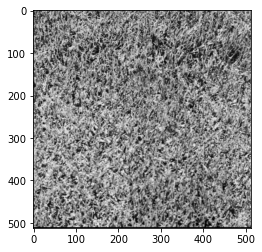

In [ ]:
smpl_img = Image.open("textures/textures/1.1.01.tiff").convert('RGB')
plt.imshow(smpl_img)

## Data Augmentation Using Transforms

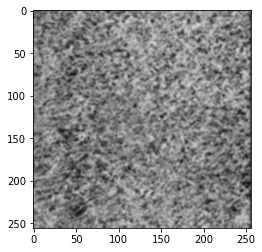

In [ ]:
img_size = 256

R0 = transforms.RandomRotation((0, 0))
R90 = transforms.RandomRotation((90, 90))
R180 = transforms.RandomRotation((180, 180))
R270 = transforms.RandomRotation((-90, -90))

RR = transforms.RandomChoice([R0, R90, R180, R270])
RHF = transforms.RandomHorizontalFlip(0.5)
RVF = transforms.RandomVerticalFlip(0.5)
RGB = transforms.GaussianBlur(3)

RS = transforms.Resize((img_size, img_size))

TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()
myTransforms = transforms.Compose([RS, RR, RHF, RVF, RGB,  TT])

img_R = myTransforms(smpl_img)
plt.imshow(TPIL(img_R))

## DataLoader Class

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.transforms = transforms
    self.files = glob.glob(root + '/*.*')
    
  def __getitem__(self, index):
    rand_im = Image.open(random.choice(self.files)) #Open random image file
    tr_im = self.transforms(rand_im) #Transform random image                         

    return tr_im
  
  def __len__(self):
    return len(self.files)

## Instantiating DataLoader

Number of Batches: 218
Data shape:  torch.Size([8, 3, 256, 256])


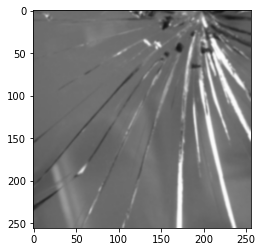

In [ ]:
# Prepare the data
data_path = 'textures/textures2/'
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(ImageDataset(data_path,
                                                            transforms=myTransforms),
                                              batch_size=batch_size,
                                              shuffle=True)

print('Number of Batches:', len(train_dataloader))
smpl_batch = next(iter(train_dataloader))
print('Data shape: ', smpl_batch.shape)
plt.imshow(TPIL(smpl_batch[0]).convert('RGB'))

## The Model! :)

In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self, nc, nfm, img_size):
    super(Discriminator, self).__init__()
    exp = int( math.log(img_size)/math.log(2) )
    self.llayers =  nfm*(2**(exp-4) )
    
    # d2l -> lth-layer, according to paper
    self.d2l = [nn.Conv2d(nc, nfm, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2, inplace=True)]

    for i in range(exp-4):
      self.d2l += [nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1, bias=False),
                   nn.BatchNorm2d( nfm*( 2**(i+1) ) ),
                   nn.LeakyReLU(0.2, inplace=True)]

    self.d2l = nn.Sequential(*self.d2l)
    
    self.fc = [nn.Linear( nfm*(2**(exp-4) )*8*8 , 512),
               nn.LeakyReLU(0.2, inplace=True),
               nn.Linear( 512 , 1), 
               nn.Sigmoid()]

    self.fc = nn.Sequential(*self.fc)
    
  def forward(self, inputs):
    l_layer = self.d2l(inputs).view(-1,self.llayers*8*8)
    pred = self.fc(l_layer)
    return l_layer, pred


class Encoder(torch.nn.Module):
  def __init__(self, nc, nfm, nz=128, img_size=512):
    super(Encoder, self).__init__()
    exp = int( math.log(img_size)/math.log(2) )

    self.e = [nn.Conv2d(nc, nfm, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2)]

    for i in range(exp-5):
      self.e += [nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1, bias=False),
                 nn.BatchNorm2d( nfm*( 2**(i+1) ), momentum=0.9 ),
                 nn.LeakyReLU(0.2)]

    self.e += [nn.Conv2d( nfm*(2**(exp-5)), nfm*(2**(exp-4)), 4, 2, 1, bias=False),
                 nn.BatchNorm2d( nfm*(2**(exp-4)), momentum=0.9 ),
                 nn.LeakyReLU(0.2)]
    
    self.fc = [nn.Linear(8*8*nfm*(2**(exp-4)),2048, bias=False),
#               nn.BatchNorm1d(2048, momentum=0.9),
              nn.LeakyReLU(0.2)]
    
    self.e = nn.Sequential(*self.e)
    self.fc = nn.Sequential(*self.fc)

    self.mu = nn.Linear(2048, nz)
    self.var = nn.Linear(2048, nz)
    
  def forward(self, inputs):
    enc = self.e(inputs)
    enc = enc.view(enc.shape[0], -1)
    enc = self.fc(enc)
    mu = self.mu(enc)
    logvar = self.var(enc)
    
    return mu, logvar

class Generator(torch.nn.Module):
  def __init__(self, nc, nfm, nz, img_size):
    super(Generator, self).__init__()
    exp = int( math.log(img_size)/math.log(2) )
    
    self.fc = [nn.Linear(nz, 8*8*nfm*(2**(exp-4)), bias=False),
              nn.LeakyReLU(0.2)]
    
    self.g = []
    
    for i in range(exp-4):
      self.g += [nn.ConvTranspose2d(nfm*(2**(exp-4-i)) , nfm*(2**(exp-4-i-1)), 4, 2, 1, bias=False),
                  nn.BatchNorm2d(nfm*(2**(exp-4-i-1))),
                  nn.ReLU(inplace=False)]
      
    self.g += [nn.ConvTranspose2d(nfm, nc, 4, 2, 1, bias=False),
               nn.Tanh()]
    
    self.fc = nn.Sequential(*self.fc)
    self.g = nn.Sequential(*self.g)
    
  def forward(self, inputs):
    featureMaps = self.fc(inputs).view(inputs.shape[0],-1,8,8)
    return self.g(featureMaps)

class VAE(nn.Module):
    def __init__(self, nc, nfm, nz, img_size):
        super(VAE, self).__init__()
        self.nz = nz
        self.e = Encoder(nc, nfm, nz, img_size)
        self.g = Generator(nc, nfm, nz, img_size)

    def forward(self, x=None, mode='train'):
        if mode == 'train':
            mean, logvar = self.e(x)
            std = logvar.mul(0.5).exp_()

            latent_z = torch.randn(x.shape[0], self.nz).cuda()
            latent_z = latent_z * std + mean  
            rec_img = self.g(latent_z)

            latent_z = torch.randn(x.shape[0], self.nz).cuda()
            gen_img = self.g(latent_z)

            return rec_img, gen_img, mean, logvar

        latent_z = torch.randn(8, self.nz).cuda()
        if x is not None:
            mean, logvar = self.e(x)
            std = logvar.mul(0.5).exp_()
            latent_z = latent_z * std + mean

        return self.g(latent_z)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Helper Functions

In [ ]:
def ones_target(batch_size):
  ones = torch.ones(batch_size, 1)
  if torch.cuda.is_available(): return ones.cuda()
  
  return ones

def zeros_target(batch_size):
  zeros = torch.zeros(batch_size, 1)
  if torch.cuda.is_available(): return zeros.cuda()
  
  return zeros

def create_latent_z(batch_size, nz):
  n = torch.randn(batch_size, nz)
  if torch.cuda.is_available(): return n.cuda()
  
  return n


def train(real_train, 
          vae, d, 
          e_optim, g_optim, d_optim, 
          rec_criterion, adv_criterion):
    
  N = real_train.shape[0]
  labels_real = ones_target(N)
  labels_fake = zeros_target(N)

  ###### TRAIN DISCRIMINATOR ######
  rec_imgs, gen_imgs, _, _ = vae(imgs)
  
  _, preds_real = d(real_train)
  _, preds_rec = d(rec_imgs.detach())
  _, preds_gen = d(gen_imgs.detach())
  
  
  error_adv_real = adv_criterion(preds_real, labels_real)
  error_adv_rec  = adv_criterion(preds_rec, labels_fake)
  error_adv_gen  = adv_criterion(preds_gen, labels_fake)
  error_adv  = error_adv_real + error_adv_rec + error_adv_gen

  d_optim.zero_grad()
  error_adv.backward()
  d_optim.step()
  #################################

  ###### TRAIN Decoder ######
  llayer_dec_real, _ = d(real_train)
  llayer_dec_rec, preds_dec_rec  = d(rec_imgs)
  _, preds_dec_gen  = d(gen_imgs)
  error_dec_adv_rec  = adv_criterion(preds_dec_rec, labels_fake)
  error_dec_adv_gen  = adv_criterion(preds_dec_gen, labels_fake)
  error_dec_adv = error_dec_adv_rec + error_dec_adv_gen
  error_dec_rec = rec_criterion(llayer_dec_rec, llayer_dec_real)

  error_dec = 0.5*error_dec_rec - error_dec_adv

  g_optim.zero_grad()
  error_dec.backward()
  g_optim.step()
  #################################
    
  ###### TRAIN Encoder ######
  rec_enc_imgs, _, mu, logvar = vae(imgs)

  llayer_enc_real, _ = d(real_train)
  llayer_enc_rec, _ = d(rec_enc_imgs)
  error_enc_rec = rec_criterion(llayer_enc_rec, llayer_enc_real)
  error_kl = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - logvar - 1) / torch.numel(mu.data)
  error_enc = error_kl + error_enc_rec

  e_optim.zero_grad()
  error_enc.backward()
  e_optim.step()
  #################################

  return error_adv.item(), error_dec_rec.item(), error_kl.item()

def save_generated_samples(fakes_samples, epoch):
  save_imgs = torchvision.utils.make_grid(fakes_samples, nrow=4)
  torchvision.utils.save_image(save_imgs, 'Epoch_'+str(epoch)+'_images.png')
  

In [ ]:
# vae = VAE(3, 32, 128, 512).cuda()
# d = Discriminator(3, 32, 512).cuda()
# img = torch.randn(5, 3, 512, 512).cuda()
# img1, img2, _, _ = vae(img)
# print(img1.shape, img2.shape)
# print(d(img1), d(img2))
# gen_imgs = vae(mode='test')
# save_generated_samples(gen_imgs, 10)

In [ ]:
nc = 3
nfm = 16
nz = 128
img_size = 256
epochs = 1500
lr=3e-4
alpha=0.1
gamma=0.01

#Networks
d = Discriminator(nc, nfm, img_size)
vae = VAE(nc, nfm, nz, img_size)

d.apply(weights_init), vae.g.apply(weights_init), vae.e.apply(weights_init)
d.load_state_dict(torch.load('discriminator_weights.pth'))
vae.load_state_dict(torch.load('vae_weights.pth'))

#Optimizers
optim_d=torch.optim.Adam(d.parameters(), lr=lr)
optim_e=torch.optim.Adam(vae.e.parameters(), lr=lr)
optim_g=torch.optim.Adam(vae.g.parameters(), lr=lr*alpha)

#Loss
adv_criterion = nn.BCELoss()
rec_criterion = nn.L1Loss()

if torch.cuda.is_available(): d, vae = d.cuda(), vae.cuda()

In [ ]:
losses = []

for i in range(epochs):
  loss = np.array([0,0,0])

  for batch in train_dataloader:
    if torch.cuda.is_available(): imgs = batch.cuda()

    error_adv, error_rec, error_kl = train(imgs, 
                                           vae, d, 
                                           optim_e, optim_g, optim_d,
                                           rec_criterion, adv_criterion)
    
    
  batches = len(train_dataloader)
  loss = np.array([error_adv, error_rec, error_kl])/batches
  print('Epoch', str(i),'Adversarial Loss :', loss[0], "KL Loss :", loss[2], "Reconstruction Loss:", loss[1])
  losses.append(loss)
  
  if i%5==0:
    rec_imgs = vae(imgs, mode='test')
    gen_imgs = vae(mode='test')
    save_imgs = torch.cat([rec_imgs, gen_imgs], axis=0)
    save_generated_samples(save_imgs, i)
    
    torch.save(d.state_dict(), 'discriminator_weights.pth')
    torch.save(vae.state_dict(), 'vae_weights.pth')
    
# plt.title('GAN Loss Graph')
# plt.plot(d_losses, label='Disc Loss')
# plt.legend()
# plt.show()

#plt.savefig('GAN_loss.png')

Epoch 0 Adversarial Loss : 1.6916830545513456e-05 KL Loss : 0.00013900371353834048 Reconstruction Loss: 0.0015125312936415366
Epoch 1 Adversarial Loss : 9.788147525203952e-07 KL Loss : 0.00013338538621543745 Reconstruction Loss: 0.001890569515184525
Epoch 2 Adversarial Loss : 6.292889817455493e-05 KL Loss : 0.00017414059182372662 Reconstruction Loss: 0.001974067283332895
Epoch 3 Adversarial Loss : 3.431402313362256e-08 KL Loss : 0.0001081986045208546 Reconstruction Loss: 0.001914110615712787
Epoch 4 Adversarial Loss : 1.1210141740466997e-08 KL Loss : 0.0001139488720565761 Reconstruction Loss: 0.0024960631624274298
Epoch 5 Adversarial Loss : 1.3568321740363699e-08 KL Loss : 0.0001870062749046798 Reconstruction Loss: 0.002219450309735919
Epoch 6 Adversarial Loss : 0.0013226508547406679 KL Loss : 0.00016647233807165688 Reconstruction Loss: 0.001989765314880861
Epoch 7 Adversarial Loss : 1.8113926195896257e-08 KL Loss : 0.00012068146275817801 Reconstruction Loss: 0.0014516446021718716
Epoc

Epoch 66 Adversarial Loss : 0.002193117497164175 KL Loss : 0.00014464478563824926 Reconstruction Loss: 0.0013593170074147915
Epoch 67 Adversarial Loss : 1.4850428077464906e-07 KL Loss : 8.804499761227075e-05 Reconstruction Loss: 0.0016428132396225535
Epoch 68 Adversarial Loss : 2.955486640171789e-07 KL Loss : 0.000121028871711241 Reconstruction Loss: 0.0017645043244055652
Epoch 69 Adversarial Loss : 1.9779228517217475e-07 KL Loss : 0.00018562321816015682 Reconstruction Loss: 0.0015849759545894938
Epoch 70 Adversarial Loss : 9.425759845233839e-06 KL Loss : 0.00010912178443112505 Reconstruction Loss: 0.0015786869810261858
Epoch 71 Adversarial Loss : 1.3875929119280078e-08 KL Loss : 0.00014055070868872722 Reconstruction Loss: 0.0016897657048811606
Epoch 72 Adversarial Loss : 6.759320513917766e-05 KL Loss : 7.700610803354771e-05 Reconstruction Loss: 0.0018079909709615444
Epoch 73 Adversarial Loss : 2.7074553862795095e-06 KL Loss : 0.00016737360199657055 Reconstruction Loss: 0.0014775797314

Epoch 132 Adversarial Loss : 0.0033755105569821977 KL Loss : 6.900736293114653e-05 Reconstruction Loss: 0.0014598763317143152
Epoch 133 Adversarial Loss : 8.566498141223137e-05 KL Loss : 0.00011782073031324859 Reconstruction Loss: 0.0014505569541126216
Epoch 134 Adversarial Loss : 1.855438720400727e-05 KL Loss : 7.324772587883363e-05 Reconstruction Loss: 0.0019285311119272076
Epoch 135 Adversarial Loss : 3.36173619570877e-06 KL Loss : 6.479721670167162e-05 Reconstruction Loss: 0.0015859417959090767
Epoch 136 Adversarial Loss : 1.0003909706821614e-06 KL Loss : 9.39633304236132e-05 Reconstruction Loss: 0.0012279908864869984
Epoch 137 Adversarial Loss : 3.8441784445991005e-07 KL Loss : 0.00011819303719275589 Reconstruction Loss: 0.0014547985901526355
Epoch 138 Adversarial Loss : 9.932159419479105e-07 KL Loss : 0.00010275052979998633 Reconstruction Loss: 0.00166615023525483
Epoch 139 Adversarial Loss : 0.0001559619270606872 KL Loss : 6.762279812759216e-05 Reconstruction Loss: 0.00182522231

Epoch 197 Adversarial Loss : 2.4375974610789652e-06 KL Loss : 9.996228671948845e-05 Reconstruction Loss: 0.0012917882258738946
Epoch 198 Adversarial Loss : 1.981447946382772e-05 KL Loss : 7.962786652352832e-05 Reconstruction Loss: 0.001212809063972683
Epoch 199 Adversarial Loss : 2.5812694546552974e-06 KL Loss : 7.677549034903902e-05 Reconstruction Loss: 0.001453560973526141
Epoch 200 Adversarial Loss : 3.8940427849419554e-07 KL Loss : 8.286682700892108e-05 Reconstruction Loss: 0.0013855664281670107
Epoch 201 Adversarial Loss : 6.34993727686345e-06 KL Loss : 5.88619534712319e-05 Reconstruction Loss: 0.0013855459219818814
Epoch 202 Adversarial Loss : 1.0212604864286856e-06 KL Loss : 0.0001240110947588168 Reconstruction Loss: 0.0010338493990241933
Epoch 203 Adversarial Loss : 0.0011249836021607076 KL Loss : 9.726125473549606e-05 Reconstruction Loss: 0.001176020147603586


KeyboardInterrupt: 

In [ ]:
# Started Training @ 2:10AM 34 epochs
# 83 epochs @ 10:20

In [ ]:
save_generated_samples(gen_imgs, 10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1d9b2dc-0aa6-4b59-8bd7-0b3848a2d4a6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>